In [1]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
# just set the seed for the random number generator
np.random.seed(107)

import matplotlib.pyplot as plt

from backtester.trading_system_parameters import TradingSystemParameters
from datetime import timedelta
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from backtester.dataSource.nse_data_source import NSEStockDataSource
from backtester.executionSystem.simple_execution_system import SimpleExecutionSystem
from backtester.executionSystem.pair_execution_system import PairExecutionSystem
from backtester.orderPlacer.backtesting_order_placer import BacktestingOrderPlacer
from backtester.trading_system import TradingSystem
from backtester.constants import *
from backtester.timeRule.us_time_rule import USTimeRule
from backtester.features.feature import Feature

In [2]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [22]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

startDateStr = '2012/12/01'
endDateStr = '2020/05/01'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['SPY','AAPL','GOOGL','AMZN','MSFT','INTC','AMD','KO','PEP','MCD','SBUX','CMG']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']

Processing data for stock: SPY
Processing data for stock: AAPL
Processing data for stock: GOOGL
Processing data for stock: AMZN
Processing data for stock: MSFT
Processing data for stock: INTC
Processing data for stock: AMD
Processing data for stock: KO
Processing data for stock: PEP
Processing data for stock: MCD
Processing data for stock: SBUX
Processing data for stock: CMG
20% done...
40% done...
60% done...
80% done...


In [4]:
data.head(3)

,SPY,AAPL,GOOGL,AMZN,MSFT,INTC,AMD,KO,PEP,MCD,SBUX,CMG
2007-11-30,114.876030,22.535343,346.846832,90.559998,25.232943,17.831505,9.76,18.515615,53.202648,40.145603,9.874459,133.149994
2007-12-03,114.118706,22.119802,341.106110,90.910004,24.722271,17.947742,9.66,18.545437,52.789074,41.079380,9.629601,132.929993
2007-12-04,113.098663,22.237297,342.422424,94.410004,24.609631,17.988766,9.25,18.709425,52.837307,41.216698,9.431180,137.509995


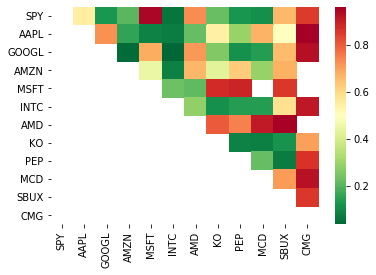

[('GOOGL', 'AMZN'), ('GOOGL', 'INTC')]


In [10]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks

scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
                yticklabels=instrumentIds, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
plt.show()
print(pairs)

0.03639339093021251 -3.4570921096905938


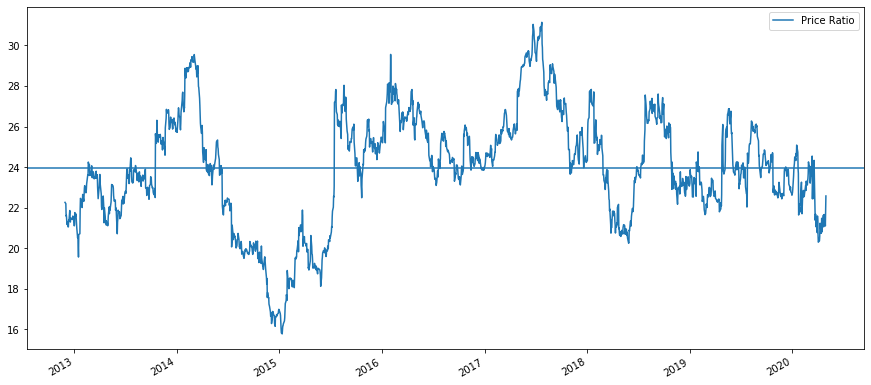

In [23]:
S1 = data['GOOGL']
S2 = data['INTC']
score, pvalue, _ = coint(S1, S2)
print(pvalue, score)
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

In [24]:
def zscore(series, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ma1 = series.rolling(window=window1,
                               center=False).mean()
    ma2 = series.rolling(window=window2,
                               center=False).mean()
    std = series.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    return zscore

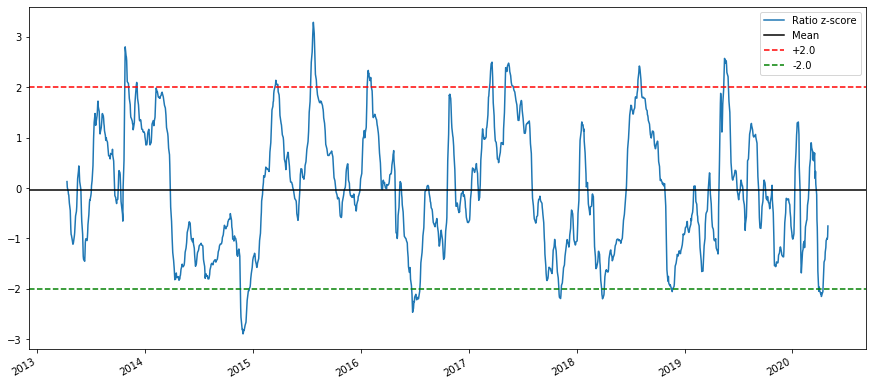

In [25]:
zscore(ratios, 6, 90).plot(figsize=(15,7))
plt.axhline(zscore(ratios, 6, 90).mean(), color='black')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+2.0', '-2.0'])
plt.show()

In [ ]:
ratios = data['ADBE'] / data['MSFT']
print(len(ratios))
train = ratios[:1762]
test = ratios[1762:]

In [14]:
# Инициализировать статистику
#
# Получить даты для которых нужно бежать
#
# Определить минимальный размер данных для анализа и посчитать их (пропустить даты до определенного значения)
#
# Вызывать функцию прогноза для каждого дня торгового периода и получить данные прогноза
#
# В зависимости от прогноза открывать и закрывать сделки (фиксировать цену открытия и закрития сделки, считать прибыль, обновлять статистику)
#
#
#
#
def backtest(predictions, leverage, startDeposit):
    
    

#
#
#
def trade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] + S2[i] * countS2
            countS1 = 0
            countS2 = 0
#         print('Z-score: '+ str(zscore[i]), countS1, countS2, S1[i] , S2[i])
    return money

In [7]:
class PairValuePredictionFeature(Feature):

    @classmethod
    def computeForInstrument(cls, updateNum, time, featureParams, featureKey, instrumentManager):
    # def computeForMarket(cls, updateNum, time, featureParams, featureKey, currentMarketFeatures, instrumentManager):
        lookbackInstrumentFeatures = instrumentManager.getLookbackInstrumentFeatures()
        
        maLongData = lookbackInstrumentFeatures.getFeatureDf('ma_long').iloc[-1]
        
        print(maLongData)

        return [0.5, 0.5, 0.5]

In [17]:
class MyTradingParams(TradingSystemParameters):
    
    def __init__(self, instrumentIds, shortPeriod, longPeriod, startDate, endDate, benchMarkId):
        self.count = 0
        self.params = {}
        self.start = startDate
        self.end = endDate
        self.instrumentIds = instrumentIds
        self.shortPeriod = shortPeriod
        self.longPeriod = longPeriod
        self.benchMarkId = benchMarkId
        super(MyTradingParams, self).__init__()
    '''
    Returns an instance of class DataParser. Source of data for instruments
    '''

    def getDataParser(self):
        return YahooStockDataSource(cachedFolderName='yahooData/',
                                     dataSetId='testPairsTrading',
                                     instrumentIds=self.instrumentIds + [self.benchMarkId],
                                     startDateStr=self.start,
                                     endDateStr=self.end)

    '''
    This is a way to use any custom features you might have made.
    Returns a dictionary where
    key: featureId to access this feature (Make sure this doesnt conflict with any of the pre defined feature Ids)
    value: Your custom Class which computes this feature. The class should be an instance of Feature
    Eg. if your custom class is MyCustomFeature, and you want to access this via featureId='my_custom_feature',
    you will import that class, and return this function as {'my_custom_feature': MyCustomFeature}
    '''

    def getBenchmark(self):
        return self.benchMarkId
    
    def getCustomFeatures(self):
        return {'pairvalue_prediction': PairValuePredictionFeature}
    
    def getStartingCapital(_):
        return 1000

    def getTimeRuleForUpdates(self):
        return USTimeRule(startDate = self.start,
                          endDate = self.end,
                          frequency='D')

    '''
    Returns a dictionary with:
    key: string representing instrument type. Right now INSTRUMENT_TYPE_OPTION, INSTRUMENT_TYPE_STOCK, INSTRUMENT_TYPE_FUTURE
    value: Array of instrument feature config dictionaries
        feature config Dictionary has the following keys:
        featureId: a string representing the type of feature you want to use
        featureKey: {optional} a string representing the key you will use to access the value of this feature.
                    If not present, will just use featureId
        params: {optional} A dictionary with which contains other optional params if needed by the feature
    Example:
    positionConfigDict = {'featureId': 'position'}
    vwapConfigDict = {'featureKey': 'price',
                          'featureId': 'vwap'}
    movingAvg_30Dict = {'featureKey': 'mv_avg_30',
                          'featureId': 'moving_average',
                          'params': {'days': 30}}
    movingAvg_90Dict = {'featureKey': 'mv_avg_90',
                          'featureId': 'moving_average',
                          'params': {'days': 90}}
    return {INSTRUMENT_TYPE_FUTURE: [positionConfigDict, vwapConfigDict],
            INSTRUMENT_TYPE_STOCK: [positionConfigDict, movingAvg_30Dict, movingAvg_90Dict]}

    For each future instrument, you will have features keyed by position and price.
    For each stock instrument, you will have features keyed by position, mv_avg_30, mv_avg_90
    '''

    def getInstrumentFeatureConfigDicts(self):
        print(self)
        # ADD RELEVANT FEATURES HERE
        maLongDict = {'featureKey': 'ma_long',
                   'featureId': 'moving_average',
                   'params': {'period': self.longPeriod,
                              'featureName': 'adjClose'}}
        maShortDict = {'featureKey': 'ma_short',
                   'featureId': 'moving_average',
                   'params': {'period': self.shortPeriod,
                              'featureName': 'adjClose'}}
        position = {'featureKey': 'position',
                    'featureId': 'position',
                    'params': {}}
        predictionDict = {'featureKey': 'prediction',
                                'featureId': 'pairvalue_prediction',
                                'params': {}}

        return {INSTRUMENT_TYPE_STOCK: [maLongDict, maShortDict, position, predictionDict]}

    '''
    Returns an array of market feature config dictionaries
        market feature config Dictionary has the following keys:
        featureId: a string representing the type of feature you want to use
        featureKey: a string representing the key you will use to access the value of this feature.this
        params: A dictionary with which contains other optional params if needed by the feature
    '''

    def getMarketFeatureConfigDicts(self):
        # ADD RELEVANT FEATURES HERE

        # customFeatureDict = {'featureKey': 'custom_mrkt_feature',
        #                      'featureId': 'my_custom_mrkt_feature',
        #                      'params': {'param1': 'value1'}}
        return []
    
    def getPrediction(self, time, currentMarketFeatures, instrumentManager):
        lookbackInstrumentFeatures = instrumentManager.getLookbackInstrumentFeatures()
        
        maLongData = lookbackInstrumentFeatures.getFeatureDf('ma_long')
        
        print(maLongData)

        
        return [0.5, 0.5, 0.5]

    '''
    Returns the type of execution system we want to use. Its an implementation of the class ExecutionSystem
    It converts prediction to intended positions for different instruments.
    '''

    def getExecutionSystem(self):
        # return PairExecutionSystem(pair=[instrumentIds[0], instrumentIds[1]],
        #                            pairRatio=0.3,
        #                            pairEnter_threshold=0.7,
        #                            pairExit_threshold=0.55,
        #                            pairLongLimit=20000,
        #                            pairShortLimit=20000,
        #                            pairCapitalUsageLimit = 0.10*self.getStartingCapital(),
        #                            pairLotSize=200)
        return SimpleExecutionSystem(enter_threshold=0.7, exit_threshold=0.55,
                                    longLimit=10000,shortLimit=10000, capitalUsageLimit=.85,
                                    enterlotSize=10000, exitlotSize = 10000, limitType='D', price='adjClose')


            # enter_threshold=0.7,
            #                          exit_threshold=0.55,
            #                          longLimit={'ADANIPOWER.BO': 100,'RPOWER.BO': 100 * ratio},
            #                          shortLimit={'ADANIPOWER.BO': -100,'RPOWER.BO': -100 * ratio},
            #                          lotSize={'ADANIPOWER.BO': 10,'RPOWER.BO': 10 * ratio})

    '''
    Returns the type of order placer we want to use. its an implementation of the class OrderPlacer.
    It helps place an order, and also read confirmations of orders being placed.
    For Backtesting, you can just use the BacktestingOrderPlacer, which places the order which you want, and automatically confirms it too.
    '''

    def getOrderPlacer(self):
        return BacktestingOrderPlacer()

    '''
    Returns the amount of lookback data you want for your calculations. The historical market features and instrument features are only
    stored upto this amount.
    This number is the number of times we have updated our features.
    '''

    def getLookbackSize(self):
        return 90

In [18]:
tsParams = MyTradingParams(['AAPL', 'GOOGL'], 6, 90, '2007/12/01', '2009/12/01', 'SPY')
tradingSystem = TradingSystem(tsParams)
tradingSystem.startTrading(onlyAnalyze=False)

Processing data for stock: AAPL
Processing data for stock: GOOGL
Processing data for stock: SPY
20% done...
40% done...
60% done...
80% done...
2007-12-03 00:00:00
AAPL      22.119802
GOOGL    341.106110
SPY      114.118706
Name: 2007-12-03 00:00:00, dtype: float64
2007-12-04 00:00:00
AAPL      22.178550
GOOGL    341.764267
SPY      113.608685
Name: 2007-12-04 00:00:00, dtype: float64
2007-12-05 00:00:00
AAPL      22.432694
GOOGL    344.377716
SPY      114.069763
Name: 2007-12-05 00:00:00, dtype: float64
2007-12-06 00:00:00
AAPL      22.697351
GOOGL    347.780281
SPY      114.711786
Name: 2007-12-06 00:00:00, dtype: float64
2007-12-07 00:00:00
AAPL      22.963738
GOOGL    349.782782
SPY      115.092378
Name: 2007-12-07 00:00:00, dtype: float64
2007-12-10 00:00:00
AAPL      23.139473
GOOGL    351.413915
SPY      115.496783
Name: 2007-12-10 00:00:00, dtype: float64
2007-12-11 00:00:00
AAPL      23.164826
GOOGL    351.204777
SPY      115.325304
Name: 2007-12-11 00:00:00, dtype: float64
20

2008-03-10 00:00:00
AAPL      19.224038
GOOGL    294.778960
SPY      108.347436
Name: 2008-03-10 00:00:00, dtype: float64
2008-03-11 00:00:00
AAPL      19.172942
GOOGL    293.681331
SPY      108.268938
Name: 2008-03-11 00:00:00, dtype: float64
2008-03-12 00:00:00
AAPL      19.120961
GOOGL    292.617982
SPY      108.178755
Name: 2008-03-12 00:00:00, dtype: float64
2008-03-13 00:00:00
AAPL      19.073840
GOOGL    291.605250
SPY      108.094367
Name: 2008-03-13 00:00:00, dtype: float64
2008-03-14 00:00:00
AAPL      19.025730
GOOGL    290.585165
SPY      107.990035
Name: 2008-03-14 00:00:00, dtype: float64
2008-03-17 00:00:00
AAPL      18.979162
GOOGL    289.467942
SPY      107.874467
Name: 2008-03-17 00:00:00, dtype: float64
2008-03-18 00:00:00
AAPL      18.944187
GOOGL    288.513584
SPY      107.818785
Name: 2008-03-18 00:00:00, dtype: float64
2008-03-19 00:00:00
AAPL      18.904893
GOOGL    287.536593
SPY      107.729861
Name: 2008-03-19 00:00:00, dtype: float64
2008-03-20 00:00:00
AAPL

2008-06-19 00:00:00
AAPL      19.427912
GOOGL    256.872261
SPY      106.346147
Name: 2008-06-19 00:00:00, dtype: float64
2008-06-20 00:00:00
AAPL      19.490943
GOOGL    256.937938
SPY      106.316133
Name: 2008-06-20 00:00:00, dtype: float64
2008-06-23 00:00:00
AAPL      19.553741
GOOGL    257.010010
SPY      106.295344
Name: 2008-06-23 00:00:00, dtype: float64
2008-06-24 00:00:00
AAPL      19.620550
GOOGL    257.080414
SPY      106.272547
Name: 2008-06-24 00:00:00, dtype: float64
2008-06-25 00:00:00
AAPL      19.696416
GOOGL    257.314259
SPY      106.251876
Name: 2008-06-25 00:00:00, dtype: float64
2008-06-26 00:00:00
AAPL      19.757482
GOOGL    257.424480
SPY      106.196542
Name: 2008-06-26 00:00:00, dtype: float64
2008-06-27 00:00:00
AAPL      19.824195
GOOGL    257.564676
SPY      106.144860
Name: 2008-06-27 00:00:00, dtype: float64
2008-06-30 00:00:00
AAPL      19.890126
GOOGL    257.668224
SPY      106.089936
Name: 2008-06-30 00:00:00, dtype: float64
2008-07-01 00:00:00
AAPL

2008-09-25 00:00:00
AAPL      20.778482
GOOGL    252.974419
SPY      101.095815
Name: 2008-09-25 00:00:00, dtype: float64
2008-09-26 00:00:00
AAPL      20.699251
GOOGL    252.153820
SPY      100.924648
Name: 2008-09-26 00:00:00, dtype: float64
2008-09-29 00:00:00
AAPL      20.599036
GOOGL    251.214047
SPY      100.691265
Name: 2008-09-29 00:00:00, dtype: float64
2008-09-30 00:00:00
AAPL      20.511930
GOOGL    250.385774
SPY      100.498130
Name: 2008-09-30 00:00:00, dtype: float64
2008-10-01 00:00:00
AAPL      20.412925
GOOGL    249.646702
SPY      100.321830
Name: 2008-10-01 00:00:00, dtype: float64
2008-10-02 00:00:00
AAPL      20.294297
GOOGL    248.699032
SPY      100.099768
Name: 2008-10-02 00:00:00, dtype: float64
2008-10-03 00:00:00
AAPL      20.170708
GOOGL    247.690635
SPY       99.858914
Name: 2008-10-03 00:00:00, dtype: float64
2008-10-06 00:00:00
AAPL      20.049029
GOOGL    246.512846
SPY       99.562712
Name: 2008-10-06 00:00:00, dtype: float64
2008-10-07 00:00:00
AAPL

Name: 2009-01-05 00:00:00, dtype: float64
2009-01-06 00:00:00
AAPL      13.475927
GOOGL    177.396563
SPY       78.960570
Name: 2009-01-06 00:00:00, dtype: float64
2009-01-07 00:00:00
AAPL      13.362383
GOOGL    176.550439
SPY       78.651484
Name: 2009-01-07 00:00:00, dtype: float64
2009-01-08 00:00:00
AAPL      13.249746
GOOGL    175.753030
SPY       78.334858
Name: 2009-01-08 00:00:00, dtype: float64
2009-01-09 00:00:00
AAPL      13.135474
GOOGL    174.870426
SPY       77.987397
Name: 2009-01-09 00:00:00, dtype: float64
2009-01-12 00:00:00
AAPL      13.024349
GOOGL    174.032921
SPY       77.633223
Name: 2009-01-12 00:00:00, dtype: float64
2009-01-13 00:00:00
AAPL      12.916508
GOOGL    173.193582
SPY       77.287439
Name: 2009-01-13 00:00:00, dtype: float64
2009-01-14 00:00:00
AAPL      12.804338
GOOGL    172.284673
SPY       76.918393
Name: 2009-01-14 00:00:00, dtype: float64
2009-01-15 00:00:00
AAPL      12.697376
GOOGL    171.443443
SPY       76.583176
Name: 2009-01-15 00:00:0

2009-04-15 00:00:00
AAPL      11.866568
GOOGL    165.665109
SPY       65.951645
Name: 2009-04-15 00:00:00, dtype: float64
2009-04-16 00:00:00
AAPL      11.904287
GOOGL    166.247636
SPY       65.950736
Name: 2009-04-16 00:00:00, dtype: float64
2009-04-17 00:00:00
AAPL      11.936854
GOOGL    166.748859
SPY       65.928072
Name: 2009-04-17 00:00:00, dtype: float64
2009-04-20 00:00:00
AAPL      11.964941
GOOGL    167.156656
SPY       65.886066
Name: 2009-04-20 00:00:00, dtype: float64
2009-04-21 00:00:00
AAPL      11.997302
GOOGL    167.560671
SPY       65.853223
Name: 2009-04-21 00:00:00, dtype: float64
2009-04-22 00:00:00
AAPL      12.033730
GOOGL    168.025803
SPY       65.834777
Name: 2009-04-22 00:00:00, dtype: float64
2009-04-23 00:00:00
AAPL      12.071010
GOOGL    168.409131
SPY       65.814514
Name: 2009-04-23 00:00:00, dtype: float64
2009-04-24 00:00:00
AAPL      12.111065
GOOGL    168.847458
SPY       65.816608
Name: 2009-04-24 00:00:00, dtype: float64
2009-04-27 00:00:00
AAPL

2009-07-23 00:00:00
AAPL      15.998940
GOOGL    199.067790
SPY       71.264237
Name: 2009-07-23 00:00:00, dtype: float64
2009-07-24 00:00:00
AAPL      16.079285
GOOGL    199.699644
SPY       71.435630
Name: 2009-07-24 00:00:00, dtype: float64
2009-07-27 00:00:00
AAPL      16.159644
GOOGL    200.338394
SPY       71.618371
Name: 2009-07-27 00:00:00, dtype: float64
2009-07-28 00:00:00
AAPL      16.239906
GOOGL    200.948393
SPY       71.811851
Name: 2009-07-28 00:00:00, dtype: float64
2009-07-29 00:00:00
AAPL      16.311869
GOOGL    201.435769
SPY       71.954130
Name: 2009-07-29 00:00:00, dtype: float64
2009-07-30 00:00:00
AAPL      16.389218
GOOGL    201.983372
SPY       72.119962
Name: 2009-07-30 00:00:00, dtype: float64
2009-07-31 00:00:00
AAPL      16.467406
GOOGL    202.533812
SPY       72.279481
Name: 2009-07-31 00:00:00, dtype: float64
2009-08-03 00:00:00
AAPL      16.545126
GOOGL    203.083917
SPY       72.438815
Name: 2009-08-03 00:00:00, dtype: float64
2009-08-04 00:00:00
AAPL

2009-11-03 00:00:00
AAPL      21.115858
GOOGL    236.870148
SPY       81.718507
Name: 2009-11-03 00:00:00, dtype: float64
2009-11-04 00:00:00
AAPL      21.182324
GOOGL    237.509732
SPY       81.840086
Name: 2009-11-04 00:00:00, dtype: float64
2009-11-05 00:00:00
AAPL      21.253861
GOOGL    238.202147
SPY       81.971326
Name: 2009-11-05 00:00:00, dtype: float64
2009-11-06 00:00:00
AAPL      21.325192
GOOGL    238.922367
SPY       82.111800
Name: 2009-11-06 00:00:00, dtype: float64
2009-11-09 00:00:00
AAPL      21.405757
GOOGL    239.720499
SPY       82.270821
Name: 2009-11-09 00:00:00, dtype: float64
2009-11-10 00:00:00
AAPL      21.492271
GOOGL    240.600657
SPY       82.452583
Name: 2009-11-10 00:00:00, dtype: float64
2009-11-12 00:00:00
AAPL      21.579363
GOOGL    241.480648
SPY       82.629397
Name: 2009-11-12 00:00:00, dtype: float64
2009-11-13 00:00:00
AAPL      21.674246
GOOGL    242.456179
SPY       82.827096
Name: 2009-11-13 00:00:00, dtype: float64
2009-11-16 00:00:00
AAPL

{'instrument_names': [], 'instrument_stats': []}